In [1]:
%matplotlib inline

import warnings
import itertools
import numpy as np
import datetime
warnings.filterwarnings("ignore")

import lightgbm as lgb

import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from pandas.io.json import json_normalize
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import KFold
from scipy import stats

PROJ_ROOT = os.pardir

In [2]:
users_data_path = os.path.join(PROJ_ROOT, "data", "raw", "takehome_users.csv")
usage_data_path = os.path.join(PROJ_ROOT, "data", "raw", "takehome_user_engagement.csv")

users = pd.read_csv(users_data_path,encoding = "ISO-8859-1")
usage = pd.read_csv(usage_data_path,encoding = "ISO-8859-1")

In [3]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [4]:
usage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
usage3 = usage[usage.groupby('user_id').time_stamp.transform('count')>=3].copy()
usage3.head()

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


In [7]:
usage3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201002 entries, 1 to 207909
Data columns (total 3 columns):
time_stamp    201002 non-null object
user_id       201002 non-null int64
visited       201002 non-null int64
dtypes: int64(2), object(1)
memory usage: 6.1+ MB


In [8]:
usage3['time_stamp'] = pd.to_datetime(usage3['time_stamp'])

In [9]:
usage3 = usage3.set_index('time_stamp')
usage3.head()

,user_id,visited
time_stamp,,
2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2,1
2013-12-31 03:45:04,2,1


In [10]:
def adoption_calculator(ts):
    # Make dataframe with 7 day frequency and login counts for user's login time stamps
    logins = pd.DataFrame({'count': ts.time_stamp.resample('7d').count()})
    return logins['count'].between(3,7,inclusive=True).any()

In [11]:
uids = usage3['user_id'].unique()
by_user = usage3.groupby('user_id')

In [12]:
adopted = [adoption_calculator(by_user.get_group(x).index.to_frame(index = True)) for x in uids]

In [13]:
adoption = pd.DataFrame({'object_id':uids,
                         'adopted':adopted})
users = users.join(adoption.set_index('object_id'),on='object_id')
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,True
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,NaN


In [14]:
users['adopted'] = users['adopted'].fillna(False)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 949.3+ KB


In [15]:
# Fill null values in invited_by_user_id with -1
users['invited_by_user_id'] = users['invited_by_user_id'].fillna(-1)

In [16]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
adopted                       12000 non-null bool
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 949.3+ KB


In [17]:
# Change creation_source into numerical category
users['creation_source'] = users['creation_source'].apply(lambda x: 1 if x == "PERSONAL_PROJECTS" else 2 if x == 'GUEST_INVITE' 
                                                       else 3 if x == 'ORG_INVITE' else 4 if x == 'SIGNUP' else 5)

In [18]:
users['last_session_creation_time'] = users['last_session_creation_time'].fillna(users['last_session_creation_time'].median())
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 11 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null int64
last_session_creation_time    12000 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
adopted                       12000 non-null bool
dtypes: bool(1), float64(2), int64(5), object(3)
memory usage: 949.3+ KB


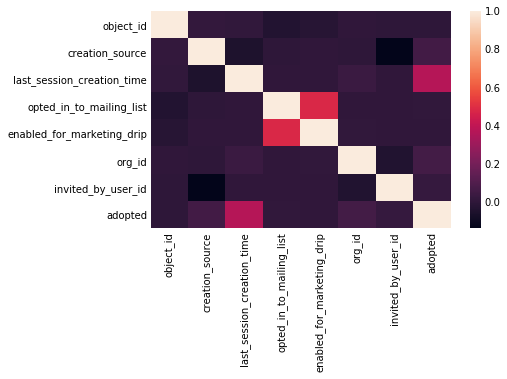

In [19]:
sns.heatmap(users.corr());

In [20]:
users.adopted.value_counts()

False    10528
True      1472
Name: adopted, dtype: int64

In [21]:
ml = users.drop(['object_id','adopted','name','email'],axis=1)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

sampling_strategy = 0.8

ros = RandomOverSampler(sampling_strategy=sampling_strategy)
X = ml[['last_session_creation_time','creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id']].values
y = users['adopted'].values
X_res, y_res = ros.fit_resample(X, y)
print('Information of the data set after making it '
      'balanced using a float and an over-sampling method: \n '
      'sampling_strategy={} \n y: {}'
      .format(sampling_strategy, Counter(y_res)))

Information of the data set after making it balanced using a float and an over-sampling method: 
 sampling_strategy=0.8 
 y: Counter({False: 10528, True: 8422})


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import make_scorer
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
SEED = 123

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, stratify=y_res, random_state=SEED)

# Instantiate Gradient Boosting classifier
gb = GradientBoostingClassifier(n_estimators=300, max_depth = 3, max_features = 3, min_samples_leaf = 2, random_state=SEED)

# Fit to training data
gb.fit(X_train, y_train)

# Predict the labels on test data
y_pred_gb = gb.predict(X_test)

# Evaluate the accuracy
accuracy_score(y_test, y_pred_gb)

0.8993843447669305

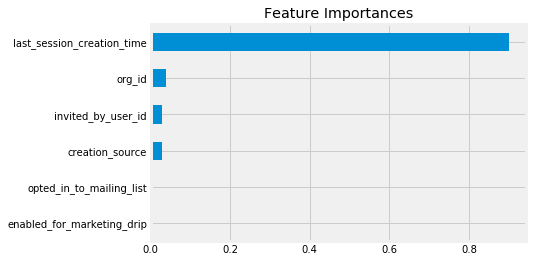

In [24]:
# Create series of the feature importances and sort the values
importances = pd.Series(gb.feature_importances_, index=['last_session_creation_time','creation_source','opted_in_to_mailing_list','enabled_for_marketing_drip','org_id','invited_by_user_id']).sort_values()

# Visualize the ranked importance of the features in a horizontal bar plot
importances.plot(kind='barh')
plt.title('Feature Importances')
plt.show();

In [25]:
# Tune hyperparameters in decision tree classifier using GridSearchCV
# Setup the parameters and distributions to sample from: param_grid
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
param_grid = {"max_depth": [3, 5, 7, 9],
              "max_features": [1,2],
              "min_samples_leaf": [0.1,1,2],
              "criterion": ["gini", "entropy"]}

# Instantiate the GridSearchCV object
grid_cv = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring=scoring, cv=5, refit='AUC', return_train_score=True)

# Fit to training data
grid_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(grid_cv.best_params_))
print("Best score is {}".format(grid_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 2, 'min_samples_leaf': 2}
Best score is 0.935042748321773


In [26]:
# Obtain the optimal decision tree model
dt_tuned = grid_cv.best_estimator_

# Fit on training set and predict on test set
dt_tuned.fit(X_train, y_train)
y_pred_tuned = dt_tuned.predict(X_test)

# Print the accuracy score on the test set
accuracy_score(y_train, dt_tuned.predict(X_train))
accuracy_score(y_test, y_pred_tuned)

0.8842568161829375